In [1]:
from google.colab import drive 
drive.mount("/content/drive", force_remount=True)
# Change directory to the package folder 
%cd '/content/drive/MyDrive/dl-project'


Mounted at /content/drive
/content/drive/MyDrive/dl-project


In [2]:
!pip install ray[tune]
!pip install transformers
!apt install libomp-dev
!python -m pip install --upgrade faiss-gpu==1.7.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.6/58.6 MB 29.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 20.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 108.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 72.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.5/468.5 kB 43.8 MB/s eta 0:00:00
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.54.0
    Uninstalling grpcio-1.54.0:
      Successfully uninstalled grpcio-1.54.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 90.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 99.5 MB/s eta 0:00:00
     ━

In [3]:
# copy dataset from google drive to the actual machine
# !rm -rf /content/data/

import os 
DATA_FOLDER = '/content/data/shopee-product-matching/'
if not os.path.isdir(DATA_FOLDER):    
    !mkdir /content/data/
    !cp /content/drive/MyDrive/dl-project/shopee-product-matching.zip /content/data/shopee-product-matching.zip
    !unzip -q /content/data/shopee-product-matching.zip -d /content/data/shopee-product-matching
    !cp /content/drive/MyDrive/dl-project/data/train.csv /content/data/shopee-product-matching/train.csv
    !cp /content/drive/MyDrive/dl-project/data/train80.csv /content/data/shopee-product-matching/train80.csv
    !cp /content/drive/MyDrive/dl-project/data/valid20.csv /content/data/shopee-product-matching/valid20.csv

In [4]:
import numpy as np
import pandas as pd

import torch
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data.dataset import Dataset
from tqdm import tqdm
from modules.datasets.ImageContrastiveLossShopeeDataset import ImageContrastiveLossShopeeDataset
from modules.datasets.ImageWithLabelsShopeeDataset import ImageWithLabelsShopeeDataset
from modules.losses.ContrastiveLoss import ContrastiveLoss
from modules.models.SiameseNet import SiameseNet
from modules.distances.CosineDistance import CosineDistance
from modules.models.ResNet18EmbeddingsShopeeNet import ResNet18EmbeddingsShopeeNet
from modules.models.DenseNetEmbeddingsShopeeNet import DenseNetEmbeddingsShopeeNet
from modules.models.ImageShopeeNet import ImageShopeeNet
import modules.utils.dataset_utils as dataset_utils
from modules.utils.CommonVIsualizer import CommonVisualizer
from modules.utils.F1ScoreEvaluator import F1ScoreEvaluator
from modules.utils.EmbeddingsProducer import EmbeddingsProducer
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler
from functools import partial
import faiss

In [5]:
train_df = dataset_utils.get_dataset(DATA_FOLDER, is_test=False, file_name='train80.csv')
train_df = dataset_utils.add_target(train_df)

valid_df = dataset_utils.get_dataset(DATA_FOLDER, is_test=False, file_name='valid20.csv')
valid_df = dataset_utils.add_target(valid_df)


all_df = train_df.append(valid_df, ignore_index=True)

all_df['rank'] = all_df['label_group'].rank(method='dense')

# map the rank values to the range 1 to N
N = len(all_df['rank'].unique())
all_df['target'] = all_df['rank'].map(lambda x: int((x-1)/(N-1)*(N-1)+1) - 1)

print(f"Min: {all_df['target'].min()}")
print(f"Max: {all_df['target'].max()}")
train_df = all_df.iloc[:train_df.shape[0]]
valid_df = all_df.iloc[train_df.shape[0]:]
print(f"All shape {all_df.shape}")
print(f"Train shape {train_df.shape}")
print(f"Valid shape {valid_df.shape}")


Min: 0
Max: 11013
All shape (34250, 8)
Train shape (27399, 8)
Valid shape (6851, 8)


<ipython-input-5-c94989668053>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = train_df.append(valid_df, ignore_index=True)


In [7]:
class CFG:
    IMG_SZ = 512
    TRAIN_RATIO = 0.8
    EPOCHS = 10
    MARGIN = 0.75
    DISTANCE = CosineDistance()



In [8]:
train_transforms = transforms.Compose([
        transforms.Resize((CFG.IMG_SZ, CFG.IMG_SZ)),
        transforms.RandomPosterize(bits=2, p=0.3),
        transforms.RandomHorizontalFlip(p=0.4),
        transforms.RandomAutocontrast(p=0.3),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
valid_transforms = transforms.Compose([
        transforms.Resize((CFG.IMG_SZ, CFG.IMG_SZ)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

train_dataset = ImageWithLabelsShopeeDataset(
    train_df['image'].values,
    train_df['target'].values,
    train_transforms,
)

valid_dataset = ImageWithLabelsShopeeDataset(
    valid_df['image'].values,
    valid_df['target'].values,
    valid_transforms,
)


print(len(train_dataset))
print(len(valid_dataset))

27399
6851


In [9]:
from ray.air import session

def get_model(config):
    return ImageShopeeNet(model_name=config["model_name"],
                          fc_dim=config["fc_dim"],
                          freeze_layers=config["freeze_layers"], 
                          dropout=config["dropout"]
                        )

def train_model(config, use_tune=True):
    model = get_model(config)
    loaded_checkpoint = session.get_checkpoint()
    if loaded_checkpoint:
        with loaded_checkpoint.as_directory() as loaded_checkpoint_dir:
           model_state, _ = torch.load(os.path.join(loaded_checkpoint_dir, "checkpoint.pt"))
        model.load_state_dict(model_state)
    fc_for_cee = torch.nn.Linear(config["fc_dim"], 11014)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    model.to(device)
    fc_for_cee.to(device)
    if torch.cuda.device_count() > 1:
        model = torch.nn.DataParallel(model)
        fc_for_cee =  torch.nn.DataParallel(fc_for_cee)
    criterion = torch.nn.CrossEntropyLoss()
    
    optimizer = optim.Adam(list(model.parameters()) + list(fc_for_cee.parameters()), lr=config['lr'])
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=config['factor'])

    loaded_checkpoint = session.get_checkpoint()
    if loaded_checkpoint:
        with loaded_checkpoint.as_directory() as loaded_checkpoint_dir:
           _, optimizer_state = torch.load(os.path.join(loaded_checkpoint_dir, "checkpoint.pt"))
        optimizer.load_state_dict(optimizer_state)
    
    
    # Datasets and data loaders
    training_sampler = torch.utils.data.SubsetRandomSampler(
        torch.arange(len(train_dataset))[:int(0.5*len(train_dataset))]
    )
    valid_sampler = torch.utils.data.SubsetRandomSampler(
        torch.arange(len(valid_dataset))[:int(0.5*len(valid_dataset))]
    )
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        sampler=training_sampler,
        batch_size=int(config["batch_size"]),
        # shuffle=True,
        num_workers=0,
    )
    valid_loader = torch.utils.data.DataLoader(
        valid_dataset,
        batch_size=int(config["batch_size"]),
        # shuffle=True,
        sampler=valid_sampler,
        num_workers=0,
    )

    train_losses = []
    valid_losses = []
    ## Training loop: training + validation
    for epoch in range(CFG.EPOCHS):
        ## Training
        train_loss = 0.0
        epoch_steps = 0
        model.train()
        fc_for_cee.train()
        train_enumerator = enumerate(train_loader, 0)
        if not use_tune:
            train_enumerator = tqdm(train_enumerator)
        for i, data in train_enumerator:
            input, target = data
            input, target = input.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(input)
            output = fc_for_cee(output)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            epoch_steps += 1
            if i % 50 == 0:
                print("[%d, %5d / %d batches] loss: %.3f" % (epoch + 1, i + 1, len(train_loader),
                                                train_loss / epoch_steps))
        

        ## Validation
        val_loss = 0.0
        model.eval()
        fc_for_cee.eval()
        valid_enumerator = enumerate(valid_loader, 0)
        if not use_tune:
            valid_enumerator = tqdm(valid_enumerator)
        for i, data in valid_enumerator:
            with torch.no_grad():
                input, target = data
                input, target = input.to(device), target.to(device)
                output = model(input)
                output = fc_for_cee(output)
                loss = criterion(output, target)
                val_loss += loss.cpu().numpy()
        if use_tune:
            with tune.checkpoint_dir(epoch) as checkpoint_dir:
                path = os.path.join(checkpoint_dir, "checkpoint")
                torch.save((model.state_dict(), optimizer.state_dict()), path)
            
            tune.report(
                val_loss=(val_loss / len(valid_loader)),
                train_loss=(train_loss / len(train_loader))
                )
        train_losses.append(train_loss)
        valid_losses.append(val_loss)
    if not use_tune:
        return model, train_losses, valid_losses

In [10]:
config_1 = {
    "model_name": tune.choice(["resnet18"]),
    "lr": tune.choice([1e-5, 1e-4, 1e-3]),
    "fc_dim": tune.choice([512, 1024]),
    "freeze_layers": tune.choice([30, 50, 50, 61]),
    "dropout": tune.choice([0.1, 0.2, 0.3]),
    "batch_size": tune.choice([32, 64]),
    "factor": tune.choice([0.1, 0.5, 0.9]),
}

config_2 = {
    "model_name": tune.choice(["densenet121"]),
    "lr": tune.choice([1e-5, 1e-4, 1e-3]),
    "fc_dim": tune.choice([512, 1024]),
    "freeze_layers": tune.choice([180, 280, 280, 361]),
    "dropout": tune.choice([0.1, 0.2, 0.3]),
    "batch_size": tune.choice([32, 64]),
    "factor": tune.choice([0.1, 0.5, 0.9]),
}


def run_hyperparameter_search(num_samples, config, max_epochs, cpus_per_trial, gpus_per_trial, name=None, resume=None):
    scheduler = ASHAScheduler(
        metric="val_loss",
        mode="min",
        max_t=max_epochs,
        grace_period=2,
        reduction_factor=3)
    reporter = CLIReporter(
        metric_columns=["train_loss", "val_loss", "training_iteration"]
        )
    result = tune.run(
        train_model,
        resources_per_trial={"cpu": cpus_per_trial, "gpu": gpus_per_trial},
        config=config,
        num_samples=num_samples,
        name=name,
        scheduler=scheduler,
        progress_reporter=reporter,
        local_dir="/root/ray_results",
        resume=resume,
        raise_on_failed_trial=False,)
    return result


In [12]:
result_1 = run_hyperparameter_search(num_samples=5, 
                                     config=config_1, 
                                     max_epochs=10, 
                                     cpus_per_trial=1, 
                                     gpus_per_trial=0.2, 
                                    #  name="train_model_2023-04-29_16-37-06", 
                                    #  resume=True
                                     )

== Status ==
Current time: 2023-05-02 18:56:00 (running for 00:00:00.23)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 6.000: None | Iter 2.000: None
Logical resource usage: 1.0/12 CPUs, 0.2/1 GPUs (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/train_model_2023-05-02_18-56-00
Number of trials: 5/5 (4 PENDING, 1 RUNNING)
+-------------------------+----------+------------------+--------------+-----------+----------+----------+-----------------+--------+--------------+
| Trial name              | status   | loc              |   batch_size |   dropout |   factor |   fc_dim |   freeze_layers |     lr | model_name   |
|-------------------------+----------+------------------+--------------+-----------+----------+----------+-----------------+--------+--------------|
| train_model_fabab_00000 | RUNNING  | 172.28.0.12:5413 |           64 |       0.3 |      0.5 |     1024 |              61 | 0.001  | resnet18     |
| train_model_fabab_00001 | PENDING  |                  |   

Trial name,date,done,hostname,iterations_since_restore,node_ip,pid,should_checkpoint,time_since_restore,time_this_iter_s,time_total_s,timestamp,train_loss,training_iteration,trial_id,val_loss
train_model_fabab_00000,2023-05-02_19-56-08,True,e9e8535f1322,10,172.28.0.12,5413,True,3604.19,356.603,3604.19,1683057368,0.427957,10,fabab_00000,19.6629
train_model_fabab_00001,2023-05-02_19-08-36,True,e9e8535f1322,2,172.28.0.12,5486,True,748.898,372.424,748.898,1683054516,5.04992,2,fabab_00001,12.803
train_model_fabab_00002,2023-05-02_19-56-14,True,e9e8535f1322,10,172.28.0.12,5488,True,3606.84,356.526,3606.84,1683057374,3.43761,10,fabab_00002,11.9683
train_model_fabab_00003,2023-05-02_19-08-42,True,e9e8535f1322,2,172.28.0.12,5490,True,754.267,374.461,754.267,1683054522,5.71068,2,fabab_00003,12.3726
train_model_fabab_00004,2023-05-02_19-56-50,True,e9e8535f1322,10,172.28.0.12,5492,True,3642.14,359.521,3642.14,1683057410,1.26803,10,fabab_00004,12.396


Streaming output truncated to the last 5000 lines.
Number of trials: 5/5 (3 RUNNING, 2 TERMINATED)
+-------------------------+------------+------------------+--------------+-----------+----------+----------+-----------------+--------+--------------+--------------+------------+----------------------+
| Trial name              | status     | loc              |   batch_size |   dropout |   factor |   fc_dim |   freeze_layers |     lr | model_name   |   train_loss |   val_loss |   training_iteration |
|-------------------------+------------+------------------+--------------+-----------+----------+----------+-----------------+--------+--------------+--------------+------------+----------------------|
| train_model_fabab_00000 | RUNNING    | 172.28.0.12:5413 |           64 |       0.3 |      0.5 |     1024 |              61 | 0.001  | resnet18     |     0.718037 |    17.4359 |                    6 |
| train_model_fabab_00002 | RUNNING    | 172.28.0.12:5488 |           64 |       0.2 |      0

2023-05-02 19:56:50,172	INFO tune.py:945 -- Total run time: 3649.89 seconds (3649.83 seconds for the tuning loop).


== Status ==
Current time: 2023-05-02 19:56:50 (running for 01:00:49.83)
Using AsyncHyperBand: num_stopped=5
Bracket: Iter 6.000: -10.7234755092197 | Iter 2.000: -10.444028783727575
Logical resource usage: 0/12 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/train_model_2023-05-02_18-56-00
Number of trials: 5/5 (5 TERMINATED)
+-------------------------+------------+------------------+--------------+-----------+----------+----------+-----------------+--------+--------------+--------------+------------+----------------------+
| Trial name              | status     | loc              |   batch_size |   dropout |   factor |   fc_dim |   freeze_layers |     lr | model_name   |   train_loss |   val_loss |   training_iteration |
|-------------------------+------------+------------------+--------------+-----------+----------+----------+-----------------+--------+--------------+--------------+------------+----------------------|
| train_model_fabab_00000 | TERMIN

In [13]:
result_2 = run_hyperparameter_search(num_samples=5, 
                                     config=config_2, 
                                     max_epochs=10,
                                     cpus_per_trial=1, 
                                     gpus_per_trial=0.2, 
                                    #  name="train_model_2023-04-29_20-30-47", 
                                    #  resume=True
                                     )

== Status ==
Current time: 2023-05-02 20:03:37 (running for 00:00:00.21)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 6.000: None | Iter 2.000: None
Logical resource usage: 1.0/12 CPUs, 0.2/1 GPUs (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/train_model_2023-05-02_20-03-37
Number of trials: 5/5 (4 PENDING, 1 RUNNING)
+-------------------------+----------+-------------------+--------------+-----------+----------+----------+-----------------+--------+--------------+
| Trial name              | status   | loc               |   batch_size |   dropout |   factor |   fc_dim |   freeze_layers |     lr | model_name   |
|-------------------------+----------+-------------------+--------------+-----------+----------+----------+-----------------+--------+--------------|
| train_model_6cb7a_00000 | RUNNING  | 172.28.0.12:23766 |           64 |       0.3 |      0.9 |      512 |             280 | 0.0001 | densenet121  |
| train_model_6cb7a_00001 | PENDING  |                  

(train_model pid=23766) Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
  0%|          | 0.00/30.8M [00:00<?, ?B/s]
100%|██████████| 30.8M/30.8M [00:00<00:00, 203MB/s]


== Status ==
Current time: 2023-05-02 20:03:45 (running for 00:00:08.66)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 6.000: None | Iter 2.000: None
Logical resource usage: 5.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/train_model_2023-05-02_20-03-37
Number of trials: 5/5 (5 RUNNING)
+-------------------------+----------+-------------------+--------------+-----------+----------+----------+-----------------+--------+--------------+
| Trial name              | status   | loc               |   batch_size |   dropout |   factor |   fc_dim |   freeze_layers |     lr | model_name   |
|-------------------------+----------+-------------------+--------------+-----------+----------+----------+-----------------+--------+--------------|
| train_model_6cb7a_00000 | RUNNING  | 172.28.0.12:23766 |           64 |       0.3 |      0.9 |      512 |             280 | 0.0001 | densenet121  |
| train_model_6cb7a_00001 | RUNNING  | 172.28.0.12:23834 |         

2023-05-02 20:03:52,508	ERROR trial_runner.py:1450 -- Trial train_model_6cb7a_00004: Error happened when processing _ExecutorEventType.TRAINING_RESULT.
ray.exceptions.RayTaskError(OutOfMemoryError): ray::ImplicitFunc.train() (pid=23840, ip=172.28.0.12, repr=train_model)
  File "/usr/local/lib/python3.10/dist-packages/ray/tune/trainable/trainable.py", line 384, in train
    raise skipped from exception_cause(skipped)
  File "/usr/local/lib/python3.10/dist-packages/ray/tune/trainable/function_trainable.py", line 336, in entrypoint
    return self._trainable_func(
  File "/usr/local/lib/python3.10/dist-packages/ray/tune/trainable/function_trainable.py", line 653, in _trainable_func
    output = fn()
  File "<ipython-input-9-3fcc04cbd35a>", line 75, in train_model
  File "/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/content/drive/MyDrive/dl-project/modules/models/ImageShopeeNet.py", line 38, 

Trial name,date,done,hostname,iterations_since_restore,node_ip,pid,should_checkpoint,time_since_restore,time_this_iter_s,time_total_s,timestamp,train_loss,training_iteration,trial_id,val_loss
train_model_6cb7a_00000,2023-05-02_21-08-25,True,e9e8535f1322,10,172.28.0.12,23766,True,3884.5398032665253,379.97362780570984,3884.5398032665253,1683061705,4.002238285818765,10,6cb7a_00000,11.9964515014931
train_model_6cb7a_00001,2023-05-02_20-18-20,True,e9e8535f1322,2,172.28.0.12,23834,True,876.4953670501709,434.4043273925781,876.4953670501709,1683058700,5.989780372672981,2,6cb7a_00001,12.756855655599523
train_model_6cb7a_00002,2023-05-02_20-18-12,True,e9e8535f1322,2,172.28.0.12,23836,True,867.7829375267029,433.58686876296997,867.7829375267029,1683058692,7.480575058072112,2,6cb7a_00002,9.461806014732078
train_model_6cb7a_00003,2023-05-02_20-18-17,True,e9e8535f1322,2,172.28.0.12,23838,True,872.8968570232391,432.81193232536316,872.8968570232391,1683058697,6.293978300961581,2,6cb7a_00003,13.205319024898388
train_model_6cb7a_00004,2023-05-02_20-03-44,,e9e8535f1322,,172.28.0.12,23840,,,,,1683057824,,,6cb7a_00004,


Streaming output truncated to the last 5000 lines.
Result logdir: /root/ray_results/train_model_2023-05-02_20-03-37
Number of trials: 5/5 (1 ERROR, 1 RUNNING, 3 TERMINATED)
+-------------------------+------------+-------------------+--------------+-----------+----------+----------+-----------------+--------+--------------+--------------+------------+----------------------+
| Trial name              | status     | loc               |   batch_size |   dropout |   factor |   fc_dim |   freeze_layers |     lr | model_name   |   train_loss |   val_loss |   training_iteration |
|-------------------------+------------+-------------------+--------------+-----------+----------+----------+-----------------+--------+--------------+--------------+------------+----------------------|
| train_model_6cb7a_00000 | RUNNING    | 172.28.0.12:23766 |           64 |       0.3 |      0.9 |      512 |             280 | 0.0001 | densenet121  |      5.42913 |   10.8082  |                    7 |
| train_model_6

2023-05-02 21:08:25,182	ERROR tune.py:941 -- Trials did not complete: [train_model_6cb7a_00004]
2023-05-02 21:08:25,184	INFO tune.py:945 -- Total run time: 3888.20 seconds (3888.13 seconds for the tuning loop).


== Status ==
Current time: 2023-05-02 21:08:25 (running for 01:04:48.13)
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 6.000: -10.259443230099148 | Iter 2.000: -9.461806014732078
Logical resource usage: 0/12 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/train_model_2023-05-02_20-03-37
Number of trials: 5/5 (1 ERROR, 4 TERMINATED)
+-------------------------+------------+-------------------+--------------+-----------+----------+----------+-----------------+--------+--------------+--------------+------------+----------------------+
| Trial name              | status     | loc               |   batch_size |   dropout |   factor |   fc_dim |   freeze_layers |     lr | model_name   |   train_loss |   val_loss |   training_iteration |
|-------------------------+------------+-------------------+--------------+-----------+----------+----------+-----------------+--------+--------------+--------------+------------+----------------------|
| train_model_6cb7a_0

In [16]:
def get_best_trial_checkpoint_and_losses(result, most_iter=True):
    best_trial = result.get_best_trial("val_loss", "min", "last")
    if most_iter:
        best_trial = result.get_best_trial("training_iteration", "max", "last")
    print("Best trial config: {}".format(best_trial.config))
    print("Best trial final training loss: {}".format(best_trial.last_result["train_loss"]))
    print("Best trial final validation loss: {}".format(best_trial.last_result["val_loss"]))

    my_trials = [ trial for trial in list(result.trial_dataframes.keys()) if str(best_trial) in trial]
    # print(my_trials)
    best_checkpoint = result.get_best_checkpoint(trial=my_trials[0], metric="val_loss", mode="min")
    train_losses = result.trial_dataframes[my_trials[0]]["train_loss"].values
    val_losses = result.trial_dataframes[my_trials[0]]["val_loss"].values
    print(f"Train losses: {val_losses}")
    print(f"Validation losses: {val_losses}")
    return best_trial, best_checkpoint, train_losses, val_losses

In [17]:
best_trial_1, best_checkpoint_1, train_losses_1, val_losses_1 = get_best_trial_checkpoint_and_losses(result_1)
print("-------------")
best_trial_2, best_checkpoint_2, train_losses_2, val_losses_2 = get_best_trial_checkpoint_and_losses(result_2, True)

Best trial config: {'model_name': 'resnet18', 'lr': 0.001, 'fc_dim': 1024, 'freeze_layers': 61, 'dropout': 0.3, 'batch_size': 64, 'factor': 0.5}
Best trial final training loss: 0.4279569084907687
Best trial final validation loss: 19.662931512903285
Train losses: [10.14063959 12.49599134 14.53343524 15.83103074 16.53208199 17.43585113
 17.87927077 18.83175423 18.98380834 19.66293151]
Validation losses: [10.14063959 12.49599134 14.53343524 15.83103074 16.53208199 17.43585113
 17.87927077 18.83175423 18.98380834 19.66293151]
-------------
Best trial config: {'model_name': 'densenet121', 'lr': 0.0001, 'fc_dim': 512, 'freeze_layers': 280, 'dropout': 0.3, 'batch_size': 64, 'factor': 0.9}
Best trial final training loss: 4.002238285818765
Best trial final validation loss: 11.9964515014931
Train losses: [ 9.36517396  9.3954194   9.46947702  9.5788795   9.87727783 10.25944323
 10.80816421 11.28781617 11.70982131 11.9964515 ]
Validation losses: [ 9.36517396  9.3954194   9.46947702  9.5788795   9.

In [18]:
def get_model_name(config):
    if config["model_name"] == 'resnet18':
        return "ResNet18"
    else:
        return "DenseNet121"
    
def losses_visualization(best_trial, train_losses, val_losses, num):
    visualizer = CommonVisualizer()
    model_name = get_model_name(best_trial.config)
    visualizer.plt_losses(train_losses, val_losses, model_name, 'Cross-entropy loss', f'./final-charts/image-cross-entropy-{num}-{model_name}.png')


def save_and_load_model(best_trial, best_checkpoint, num):
    name = get_model_name(best_trial.config)
    check_path = f'./best_contrastive_loss_image_model-{num}-{name}.pt'
    best_model = get_model(best_trial.config)

    best_checkpoint_dir = best_checkpoint.to_directory(path="directory")
    model_state, optimizer_state = torch.load(os.path.join(best_checkpoint_dir, "checkpoint"))
    best_model.load_state_dict(model_state)
    torch.save(best_model.state_dict(), check_path)
    best_model.load_state_dict(torch.load(check_path))
    return best_model

# def load_model(path):
#     best_model = 
#     best_model.load_state_dict(torch.load(check_path))
#     return best_model


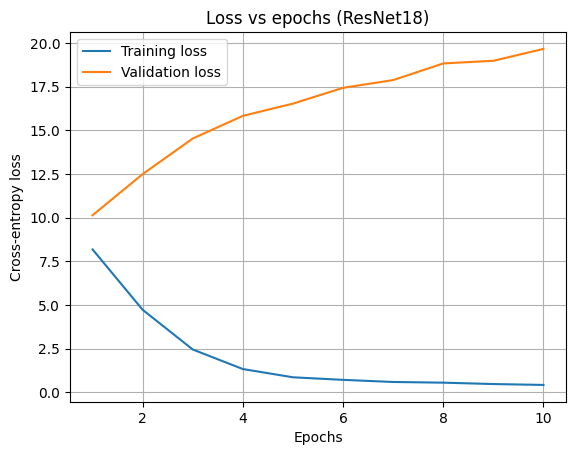

In [19]:
losses_visualization(best_trial_1, train_losses_1, val_losses_1, 1)

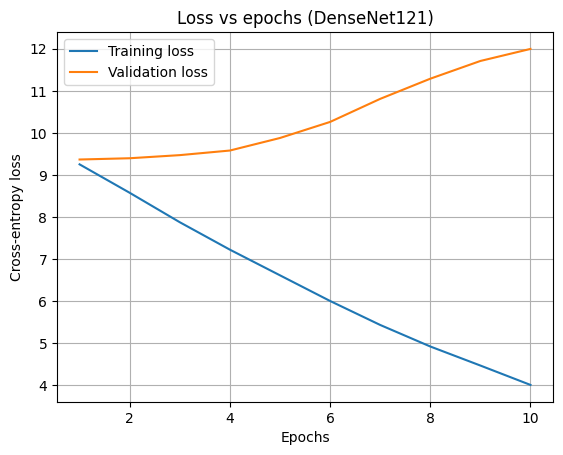

In [20]:
losses_visualization(best_trial_2, train_losses_2, val_losses_2, 2)

In [21]:
best_model_1 = save_and_load_model(best_trial_1, best_checkpoint_1, 1)

In [22]:
best_model_2 = save_and_load_model(best_trial_2, best_checkpoint_2, 2)

In [23]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
best_model_1.to(DEVICE)
best_model_2.to(DEVICE)

from modules.datasets.ImageShopeeDataset import ImageShopeeDataset

train_dataset = ImageShopeeDataset(
    train_df['image'].values,
    valid_transforms,
)

valid_dataset = ImageShopeeDataset(
    valid_df['image'].values,
    valid_transforms,
)

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=64,
    shuffle=False,
    num_workers=0
)

valid_loader = torch.utils.data.DataLoader(
    valid_dataset,
    batch_size=64,
    shuffle=False,
    num_workers=0
)


producer_1 = EmbeddingsProducer(best_model_1, DEVICE)
train_embeddings_1 = producer_1.get_embeddings(train_loader, normalize=True)
valid_embeddings_1 = producer_1.get_embeddings(valid_loader, normalize=True)
all_embeddings_1 = np.concatenate((train_embeddings_1, valid_embeddings_1))
print(all_embeddings_1.shape)

print(f"-------------")


producer_2 = EmbeddingsProducer(best_model_2, DEVICE)
train_embeddings_2 = producer_2.get_embeddings(train_loader, normalize=True)
valid_embeddings_2 = producer_2.get_embeddings(valid_loader, normalize=True)
all_embeddings_2 = np.concatenate((train_embeddings_2, valid_embeddings_2))
print(all_embeddings_2.shape)

100%|██████████| 108/108 [01:58<00:00,  1.10s/it]


(34250, 1024)
-------------


100%|██████████| 108/108 [02:09<00:00,  1.20s/it]

(34250, 512)


In [24]:
thresholds = np.arange(0.8, 0.99, 0.01)
visualizer = CommonVisualizer()

In [26]:
train_df = dataset_utils.get_dataset(DATA_FOLDER, is_test=False, file_name='train80.csv')
train_df = dataset_utils.add_target(train_df)

valid_df = dataset_utils.get_dataset(DATA_FOLDER, is_test=False, file_name='valid20.csv')
valid_df = dataset_utils.add_target(valid_df)


all_df = train_df.append(valid_df, ignore_index=True)

def evaluate_model(train_embeddings, valid_embeddings, all_embeddings):
    f1_score_eval_conter_text_train = F1ScoreEvaluator(train_df, train_embeddings, k=100)
    f1_score_eval_conter_text_valid = F1ScoreEvaluator(valid_df, valid_embeddings, k=100)
    f1_score_eval_conter_text_all = F1ScoreEvaluator(all_df, all_embeddings, k=100)

    f1_avg_scores_conter_text_train = f1_score_eval_conter_text_train.get_avg_f1_scores_for_thresholds(thresholds)
    f1_avg_scores_conter_text_valid = f1_score_eval_conter_text_valid.get_avg_f1_scores_for_thresholds(thresholds)
    f1_avg_scores_conter_text_all = f1_score_eval_conter_text_all.get_avg_f1_scores_for_thresholds(thresholds)
    return f1_avg_scores_conter_text_train, f1_avg_scores_conter_text_valid, f1_avg_scores_conter_text_all

f1s_train_1, f1s_valid_1, f1s_all_1 = evaluate_model(train_embeddings_1, valid_embeddings_1, all_embeddings_1)
f1s_train_2, f1s_valid_2, f1s_all_2 = evaluate_model(train_embeddings_2, valid_embeddings_2, all_embeddings_2)


<ipython-input-26-130116956237>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = train_df.append(valid_df, ignore_index=True)
100%|██████████| 19/19 [03:32<00:00, 11.20s/it]


In [27]:
import matplotlib.pyplot as plt 

def visualize_all(best_trial, f1_avg_scores_conter_text_train, f1_avg_scores_conter_text_valid, f1_avg_scores_conter_text_all, num):
    model_name = get_model_name(best_trial.config)

    visualizer.plt_f1_score_vs_threshold(thresholds, f1_avg_scores_conter_text_train, f'{model_name}, train', f'./final-charts/image-cross-entropy-{num}-{model_name}-thresholds-train.png')
    max_f1_text_train = max(f1_avg_scores_conter_text_train)
    max_threshold_text_train = thresholds[np.argmax(f1_avg_scores_conter_text_train)]
    plt.clf()

    visualizer.plt_f1_score_vs_threshold(thresholds, f1_avg_scores_conter_text_valid, f'{model_name} valid', f'./final-charts/image-cross-entropy-{num}-{model_name}-thresholds-valid.png')
    max_f1_text_valid = max(f1_avg_scores_conter_text_valid)
    max_threshold_text_valid = thresholds[np.argmax(f1_avg_scores_conter_text_valid)]
    plt.clf()

    visualizer.plt_f1_score_vs_threshold(thresholds, f1_avg_scores_conter_text_all, f'{model_name}', f'./final-charts/image-cross-entropy-{num}-{model_name}-thresholds-all.png')
    max_f1_text_all = max(f1_avg_scores_conter_text_all)
    max_threshold_text_all = thresholds[np.argmax(f1_avg_scores_conter_text_all)]
    plt.clf()

    print(f"{model_name}, Train | Max f1-score: {max_f1_text_train}, max threshold: {max_threshold_text_train}")
    print(f"{model_name}, Valid | Max f1-score: {max_f1_text_valid}, max threshold: {max_threshold_text_valid}")
    print(f"{model_name}, All   | Max f1-score: {max_f1_text_all}, max threshold: {max_threshold_text_all}")

visualize_all(best_trial_1, f1s_train_1, f1s_valid_1, f1s_all_1, 1)
print(f"-------------------------")
visualize_all(best_trial_2, f1s_train_2, f1s_valid_2, f1s_all_2, 2)

ResNet18, Train | Max f1-score: 0.6298069227534167, max threshold: 0.8400000000000001
ResNet18, Valid | Max f1-score: 0.6478812380470841, max threshold: 0.8
ResNet18, All   | Max f1-score: 0.6245076390832645, max threshold: 0.8500000000000001
-------------------------


DenseNet121, Train | Max f1-score: 0.6214554188088564, max threshold: 0.8900000000000001
DenseNet121, Valid | Max f1-score: 0.6378357624192235, max threshold: 0.8600000000000001
DenseNet121, All   | Max f1-score: 0.6161869170657981, max threshold: 0.8900000000000001


<Figure size 640x480 with 0 Axes>